# SIGSPATIAL 2023 : supraglacial Lake Segmentation using Attention based U-Net

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from sklearn.metrics import f1_score
from tensorflow import keras
from keras_unet_collection import models, utils

In [2]:
# 시각화 오류 해결을 위한 코드
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# user-specified working directory
filepath = 'C:/Users/scsi/Desktop/SigSpatial/U-net/data/image/'
filepath_label = 'C:/Users/scsi/Desktop/SigSpatial/U-net/data/mask/'

### Subsetting samples

COCO datatest 예시의 선택 기준 : 원본 이미지를 128x128 크기로 조정, 64x64 중앙 픽셀의 33% 이상이 인간/사람 범주에 속해야 해당 사진을 human sample로 선택한다.

이진 세그멘테이션 문제로, human이 아닌 COCO-stuff 레이블은 '배경'으로 그룹화되고 레이블이 지정된다 : non-supraglacial로 label

Supraglacial Lake의 경우 사진의 pixel 값이 하나라도 0인 경우(=supraglacial Lake가 존재하는 경우)를 추출해 학습에 사용한다.

*필요한 경우 조건을 추가해 data pre-processing이 가능.

In [4]:
def split_samples(label_filenames, supraglacial_id=0, rate=1/3):
    '''
    Subsetting samples appropriate for training
    ----------
    supraglacial_id = 255 : we label supraglacial as int 255
    rate = 1/3: at least 33% of the pixels should belong to supraglacial.
    ----------
    '''
    size = 256  # Input image size : 논문에서는 256x256
    thres = int(size*size*rate) # pixel number thres after resizing
    L = len(label_filenames)
    flag = [] # return a list of booleans
    for i in range(L):
        sample_ = utils.image_to_array([label_filenames[i]], size, channel=1)
        # 함수를 사용하여 이미지 파일을 배열로 변환. 이미지 크기는 128x128로 조정하고, 채널은 1(흑백)으로 설정.
        if np.any(sample_ == supraglacial_id): # 중앙 64x64 픽셀 중 "인간" 범주에 속하는 픽셀의 수를 검사하여, 임계값을 초과하는 경우를 판단.
            flag.append(True)
        else:
            flag.append(False)
        
    return flag

# 빙하 탐지에 사용할 사진을 선별하는데에 사용할 수 있을 것으로 생각됨.(나름의 기준을 정해서)

In [5]:
input_names = np.array(sorted(glob(filepath+'*.tif')))    # .tif로 바꿔야됨
label_names = np.array(sorted(glob(filepath_label+'*.tif')))   # .tif로 바꿔야됨

flag_supraglacial = split_samples(label_names, supraglacial_id=0)
input_names = input_names[flag_supraglacial]
label_names = label_names[flag_supraglacial]

### Training-validation data split

image 폴더 : 256x256 해상도의 원본 .tif 파일이 저장된 폴더
mask 폴더 : Supraglacial Lake를 0으로(검은색), 나머지 지역을 255(흰색)으로 라벨링한 mask가 저장된 폴더

Shuffle한 후 Training:validation:testing = 6: 2: 2의 비율로 나눔.

In [6]:
L = len(input_names)
ind_all = utils.shuffle_ind(L)  # Shuffle

L_train = int(0.6*L); L_test = int(0.2*L); L_valid = L - L_train - L_test
ind_train = ind_all[:L_train]; ind_test = ind_all[L_train:L_train + L_test]; ind_valid = ind_all[L_train + L_test:]

train_input_names = input_names[ind_train]
train_label_names = label_names[ind_train]
valid_input_names = input_names[ind_valid]
valid_label_names = label_names[ind_valid]
test_input_names = input_names[ind_test]
test_label_names = label_names[ind_test]

print("빙하가 존재하는 사진 수 : {0}".format(len(input_names)))
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names))) # 6:2:2

빙하가 존재하는 사진 수 : 3978
Training:validation:testing = 2386:797:795


### Exploratory data analysis

In [7]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

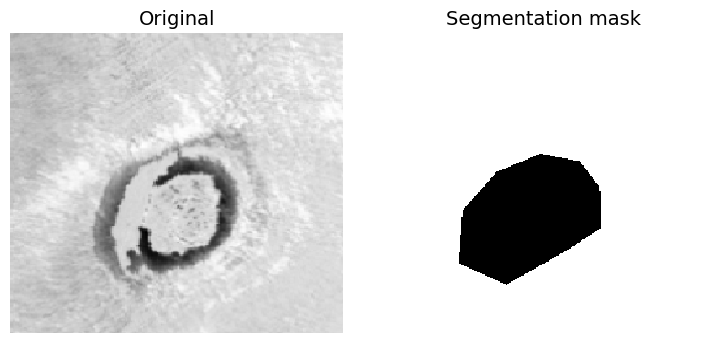

In [8]:
i_max = 10 # explore 10 images
input_example = utils.image_to_array(train_input_names[:i_max], size=256, channel=3)
label_example = utils.image_to_array(train_label_names[:i_max], size=256, channel=1)

i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
    
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0]>0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [9]:
# Example 3: attention-Unet for single target regression with:
# Four down- and upsampling levels.
# Two convolutional layers per downsampling level.
# Two convolutional layers (after concatenation) per upsampling level.
# ReLU activation, linear output activation (None), batch normalization.
# Additive attention, ReLU attention activation.
# Downsampling through stride convolutional layers.
# Upsampling through bilinear interpolation

model = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone= None, weights=None, 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [10]:
model.layers[1].name

'attunet_down0_0'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2))

c:\ProgramData\Anaconda3\envs\SIG\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [12]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1] : Min-max nomalization'''
    return input_array/255.

def target_data_process(target_array):  # 이 함수가 어떻게 작동하는지 알 필요가 있음.
    target_array[target_array>0]=1 # grouping all other non-human categories (인간 : 0, 나머지 : 1)
    return keras.utils.to_categorical(target_array, num_classes=2)

In [13]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=256, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=256, channel=1))

In [14]:
N_epoch = 200 # number of epoches
N_batch = 32 # number of batches per epoch
N_sample = 10 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 2 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=256, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=256, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

25/25 [==============================] - 74s 3s/step
	Initial loss = 0.7088209390640259
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.7088209390640259 to 0.606378436088562
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.606378436088562 to 0.5468153953552246
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.5468153953552246 to 0.4849261939525604
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.4849261939525604 to 0.42413386702537537
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.42413386702537537 to 0.36878734827041626
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.36878734827041626 to 0.3236851990222931
25/25 [==============================] - 74s 3s/step
Validation performance is improved from 0.32368519902

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [ ]:
def f1_score_(test_label, y_pred, threshold=0.5):
    y_result = np.where(y_pred > threshold, 1, 0)
    n = len(y_result)
    f1_score = 0

    for i in range(n):
        a = y_result[i,...,0]
        b = b = test_label[i,...,0]
        intersect = np.sum(a*b)
        total_sum = np.sum(a) + np.sum(b)
        dice = np.mean(2*intersect/total_sum)
        f1_score += dice/n

    return round(f1_score, 3) #round up to 3 decimal places

In [ ]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=256, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=256, channel=1))

25/25 [==============================] - 74s 3s/step


In [ ]:
# model = keras.models.load_model('result.h5')

y_pred = model.predict([test_input])
y_result = np.where(y_pred < 0.5, 0, 1)

In [ ]:
count = 0
res = 0
for i in range(test_label.shape[0]):
    true = np.argmax(test_label[i], axis = -1)
    pred = np.argmax(y_pred[i], axis = -1)
    count += 1
    res += f1_score(true,pred, average = "weighted", zero_division = 0.0)

score = res / count

In [ ]:
print(score)
print(f1_score_(test_label, y_pred, threshold=0.5))
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

0.9865161954561831
0.566
Testing set cross-entropy = 0.15186777710914612


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

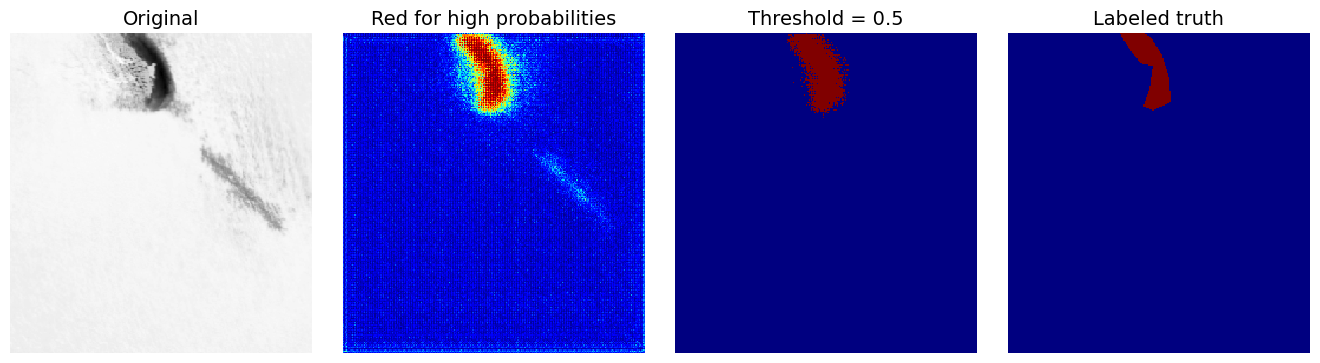

In [ ]:
i_sample = 9
n_images = 4

fig, AX = plt.subplots(1, n_images, figsize=(13, (13-0.2)/n_images))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_result[i_sample, ..., 0], cmap=plt.cm.jet)
AX[3].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Red for high probabilities", fontsize=14);
AX[2].set_title("Threshold = 0.5", fontsize=14);
AX[3].set_title("Labeled truth", fontsize=14);


In [ ]:
model.save('result.h5')